In [ ]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas


In [ ]:
import imutils

In [ ]:
!pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 86 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Panorama

In [ ]:
img_1 = cv2.imread('1.png', cv2.IMREAD_COLOR)
img_gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2 = cv2.imread('2.png', cv2.IMREAD_COLOR)
img_gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

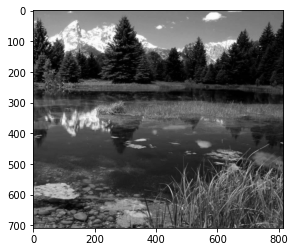

In [ ]:
plt.imshow(img_gray_1, cmap='gray')

In [ ]:
descriptor = cv2.xfeatures2d.SIFT_create()
kps_1, features_1 = descriptor.detectAndCompute(img_gray_1, None)
kps_2, features_2 = descriptor.detectAndCompute(img_gray_2, None)

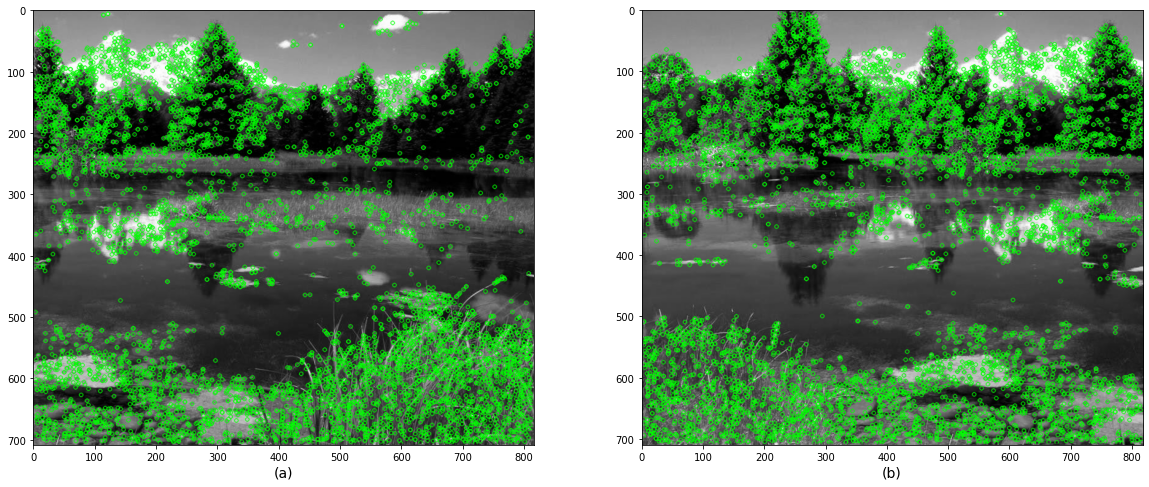

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img_gray_1,kps_1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img_gray_2,kps_2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [ ]:
best_matches = bf.match(features_1,features_2)
rawMatches = sorted(best_matches, key = lambda x:x.distance)

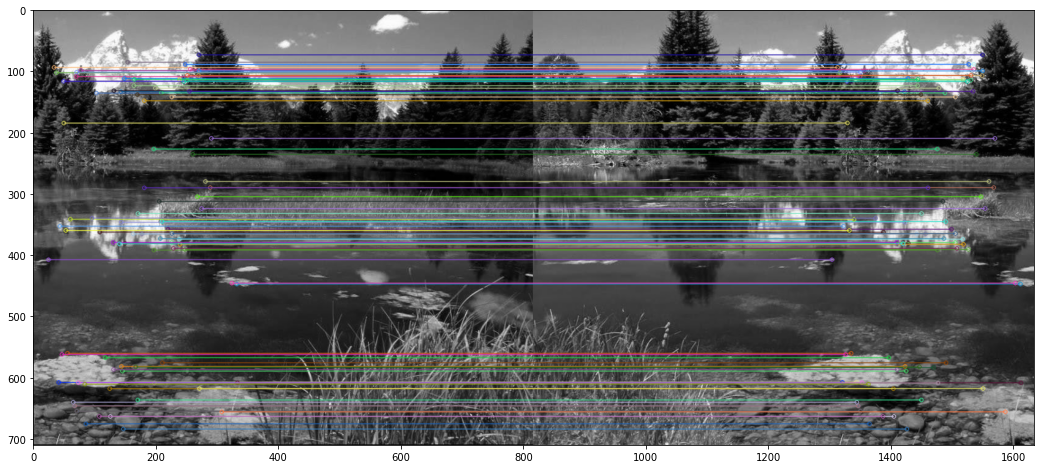

In [ ]:
fig = plt.figure(figsize=(20,8))
img3 = cv2.drawMatches(img_gray_1,kps_1,img_gray_2,kps_2,rawMatches[:100], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [ ]:
kpsA = np.float32([kp.pt for kp in kps_1])
kpsB = np.float32([kp.pt for kp in kps_2])

if len(rawMatches) > 4:

    # construct the two sets of points
    ptsA = np.float32([kpsA[m.queryIdx] for m in rawMatches])
    ptsB = np.float32([kpsB[m.trainIdx] for m in rawMatches])
    
    # estimate the homography between the sets of points
    (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4)

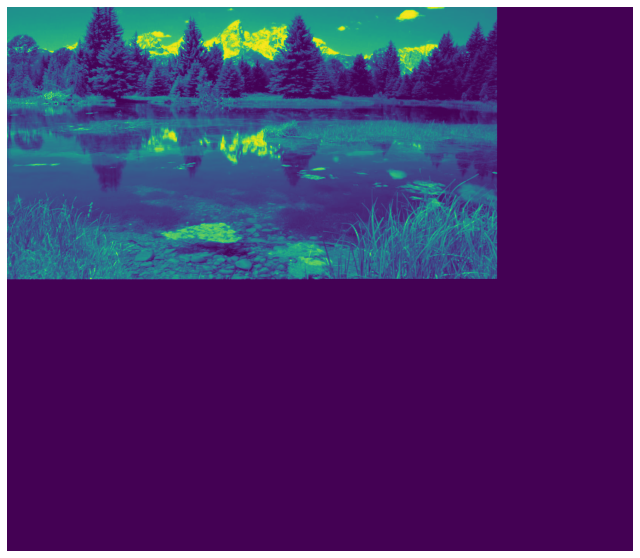

In [ ]:
width = img_gray_1.shape[1] + img_gray_2.shape[1]
height = img_gray_1.shape[0] + img_gray_2.shape[0]

result = cv2.warpPerspective(img_gray_1, H, (width, height))
result[0:img_gray_2.shape[0], 0:img_gray_2.shape[1]] = img_gray_2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

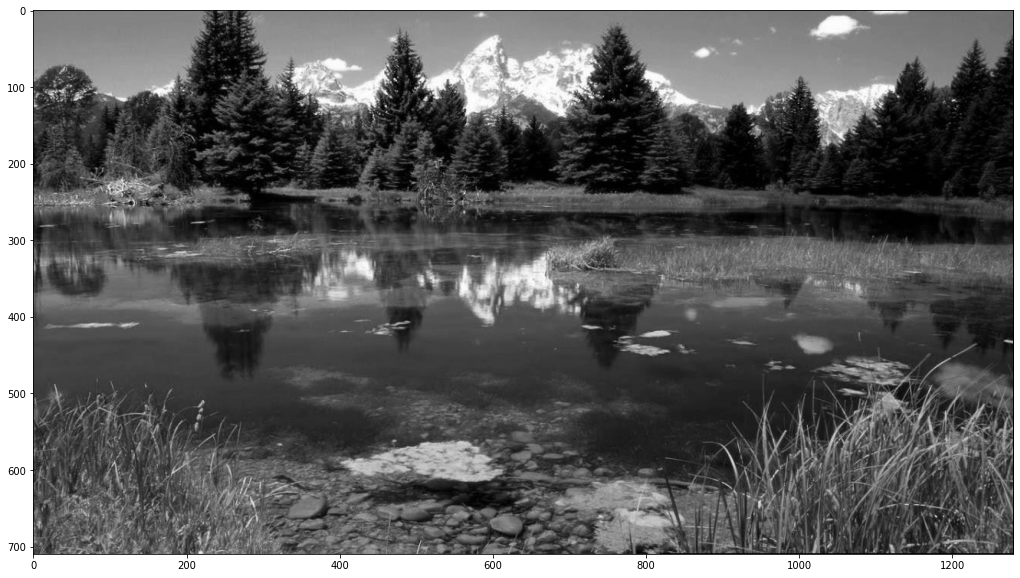

In [ ]:
# transform the panorama image to grayscale and threshold it 
thresh = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result, cmap='gray')

In [ ]:
def panorama(img_1, img_2):
  img_gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
  img_gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
  descriptor = cv2.xfeatures2d.SIFT_create()
  kps_1, features_1 = descriptor.detectAndCompute(img_gray_1, None)
  kps_2, features_2 = descriptor.detectAndCompute(img_gray_2, None)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  best_matches = bf.match(features_1,features_2)
  rawMatches = sorted(best_matches, key = lambda x:x.distance)
  kpsA = np.float32([kp.pt for kp in kps_1])
  kpsB = np.float32([kp.pt for kp in kps_2])
  if len(rawMatches) > 4:
      ptsA = np.float32([kpsA[m.queryIdx] for m in rawMatches])
      ptsB = np.float32([kpsB[m.trainIdx] for m in rawMatches])
      (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4)

  width = img_gray_1.shape[1] + img_gray_2.shape[1]
  height = img_gray_1.shape[0] + img_gray_2.shape[0]
  result = cv2.warpPerspective(img_gray_1, H, (width, height))
  result[0:img_gray_2.shape[0], 0:img_gray_2.shape[1]] = img_gray_2
  thresh = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)[1]
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  (x, y, w, h) = cv2.boundingRect(c)
  result = result[y:y + h, x:x + w]
  return result

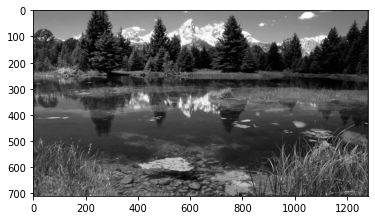

In [ ]:
plt.imshow(panorama(img_1, img_2), cmap='gray')

# Optical Flow

In [ ]:
from copy import copy

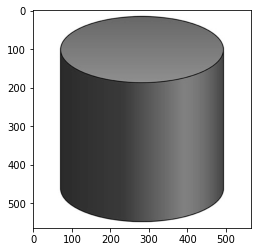

In [ ]:
cilinder = cv2.imread('3.png')
cilinder = cv2.cvtColor(cilinder, cv2.COLOR_BGR2GRAY)

plt.imshow(cilinder, cmap='gray')

In [ ]:
from scipy.stats import norm


def optical_flow_step(img1, img2, track_points, dx1, dy1, kernel_size, zero_threshold):
  kernel_border = kernel_size // 2
  p = []

  # для каждой отслеживаемой точки вычисляем смещение
  for i in range(len(track_points)):
    x_i = track_points[i][1]
    y_i = track_points[i][0]

    # массив координат точек-соседей
    pts_i = []
    
    min_shape = np.min([img1.shape, img2.shape], axis=1)
    for delta_y in range(-kernel_border, kernel_border + 1):
      for delta_x in range(-kernel_border, kernel_border + 1):
        if 0 <= y_i + delta_y < min_shape[0] and 0 <= x_i + delta_x < min_shape[1]:
          pts_i.append( (y_i + delta_y, x_i + delta_x) )

    S = np.array([ (dx1[y, x], dy1[y, x]) for y, x in pts_i ])
    T = np.array([ img1[y, x] - img2[y, x] for y, x in pts_i ])

    M_is_valid = True # флаг валидности St*S

    if len(S.shape) != 2: # случай, когда не найдены точки-соседи
      M_is_valid = False      
    else:
      M = np.dot(S.T, S)

    # проводим обрезку значений матрицы М для её корректного инвертирования
    M = np.where(np.abs(M) < zero_threshold, 0, M)

    # Проверим, есть ли решение. 
    if M_is_valid and np.linalg.det(M) <= 0:
      M_is_valid = False

    if not M_is_valid:
      p.append([0, 0])
    else:
      # вычисляем смещение точки
      p_i = np.dot(np.dot(np.linalg.inv(M), S.T), T)
      # преобразуем его в правильный формат
      p.append(p_i.ravel()[::-1])
  
  return np.array(p).astype(float)


def optical_flow(imgs, keypoints_threshold, kernel_size=5, zero_threshold=1e-3,
                 p_threshold=0.3, harris_block=3, harris_kernel=3, harris_alpha= 0.04, blur_kernel=(3,3), blur_std=2):
  x_Sobel_kernel = np.array(
    [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 2]]
  )

  y_Sobel_kernel = np.array(
    [[-1, -2, -1],
     [ 0,  0,  0],
     [ 1,  2,  1]]
  )
  
  im1 = cv2.GaussianBlur(imgs[0], blur_kernel, blur_std)
  im1f = im1 / 255  

  track_points = cv2.cornerHarris(im1, harris_block, harris_kernel, harris_alpha)
  track_points = np.array(np.where(track_points > keypoints_threshold * np.max(track_points))).T

  plot_points = [ copy(track_points) ]

  # инициализируем переменные для второго изображения
  im2 = None
  im2f = None

  for i in range(len(imgs) - 1):
    if i > 0:
      im1 = im2
      im1f = im2f

    im2 = cv2.GaussianBlur(imgs[i + 1], blur_kernel, blur_std)
    im2f = im2 / 255

    dx = cv2.filter2D(im1f, -1, x_Sobel_kernel)
    dy = cv2.filter2D(im1f, -1, y_Sobel_kernel)

    p_i = optical_flow_step(im1f, im2f, track_points, dx, dy, kernel_size, zero_threshold)

    p_i = np.where(p_i > p_threshold, np.ceil(p_i), p_i)
    p_i = np.where(p_i < -p_threshold, np.floor(p_i), p_i)
    p_i = np.where(p_i > 0, np.floor(p_i), np.ceil(p_i))
    p_i = p_i.astype(int)
    
    # сдвигаем отслеживаемые точки на величину смещения
    track_points += p_i
    plot_points.append(copy(track_points))

  return np.array(plot_points)

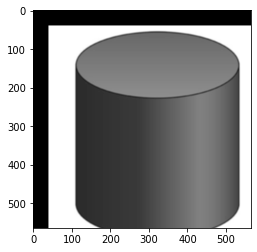

In [ ]:
imgs = [ cv2.GaussianBlur(cilinder, (5, 5), 2) ]


shift = np.array([[1, 0, 1], [0, 1, 0]]).astype(float)
for i in range(40):
  cilinder_shifted = cv2.warpAffine(imgs[i], shift, cilinder.shape[:2][::-1])
  imgs.append(cilinder_shifted)

shift = np.array([[1, 0, 0], [0, 1, 1]]).astype(float)
for i in range(40, 80):
  cilinder_shifted = cv2.warpAffine(imgs[i], shift, cilinder.shape[:2][::-1])
  imgs.append(cilinder_shifted)

plt.imshow(imgs[-1], cmap='gray')
plt.show()

In [ ]:
points = optical_flow(imgs, p_threshold=0.01, kernel_size=5, keypoints_threshold=0.5)

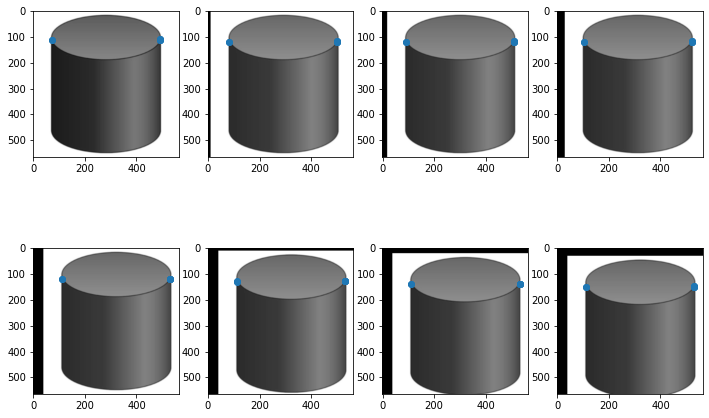

In [ ]:
nrows = 2
ncols = 4
_, axs = plt.subplots(nrows, ncols, figsize=(12, 8))

for i in range(8):
  n = i * 10
  axs[i // ncols][i % ncols].imshow(imgs[n], cmap='gray')
  axs[i // ncols][i % ncols].scatter(points[n,:, 1], points[n,:, 0])